Pradyumna Yadav (191010228)
Priyansh Sharma (191010230)
Sakshi Verma (191010239)

# Mounting drive to access dataset

### Kaggle dataset : deepfake detection dataset: https://www.kaggle.com/c/deepfake-detection-challenge/data?select=train_sample_videos

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!sudo apt-get install python==3.8.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package python=


In [4]:
!python3.8 --version

/bin/bash: python3.8: command not found


# Importing Libraries

In [ ]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle

# Preprocessing

In [ ]:
input_shape = (128, 128, 3)
data_dir = '/content/gdrive/MyDrive/191010228_191010230_191010239/dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(0)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(1)

X_pkl = '/content/gdrive/MyDrive/191010228_191010230_191010239/dataset/X_pkl.pkl'
Y_pkl = '/content/gdrive/MyDrive/191010228_191010230_191010239/dataset/Y_pkl.pkl'
with open(X_pkl,'wb') as f:
  pickle.dump(X,f)

with open(Y_pkl,'wb') as f:
  pickle.dump(Y,f)

In [ ]:
input_shape = (128, 128, 3)
X_pkl = '/content/gdrive/MyDrive/191010228_191010230_191010239/dataset/X_pkl.pkl'
Y_pkl = '/content/gdrive/MyDrive/191010228_191010230_191010239/dataset/Y_pkl.pkl'

X = pickle.load(open(X_pkl,'rb'))
Y = pickle.load(open(Y_pkl,'rb'))

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

# InceptionResNet-v2

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),metrics=['accuracy'])
model.summary()

219062272/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


# Training the model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=2,verbose=0, mode='auto')
EPOCHS = 20
BATCH_SIZE = 100
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/20
30/30 [==============================] - 74s 782ms/step - loss: 0.6580 - accuracy: 0.6779 - val_loss: 0.6356 - val_accuracy: 0.7316
Epoch 2/20
30/30 [==============================] - 16s 546ms/step - loss: 0.5527 - accuracy: 0.8275 - val_loss: 0.5933 - val_accuracy: 0.7583
Epoch 3/20
30/30 [==============================] - 17s 553ms/step - loss: 0.4660 - accuracy: 0.8941 - val_loss: 0.5709 - val_accuracy: 0.7730
Epoch 4/20
30/30 [==============================] - 17s 558ms/step - loss: 0.3883 - accuracy: 0.9260 - val_loss: 0.5422 - val_accuracy: 0.7797
Epoch 5/20
30/30 [==============================] - 17s 563ms/step - loss: 0.3235 - accuracy: 0.9380 - val_loss: 0.5302 - val_accuracy: 0.7944
Epoch 6/20
30/30 [==============================] - 17s 570ms/step - loss: 0.2541 - accuracy: 0.9565 - val_loss: 0.5180 - val_accuracy: 0.8011
Epoch 7/20
30/30 [==============================] - 17s 574ms/step - loss: 0.2074 - accuracy: 0.9619 - val_loss: 0.5001 - val_accuracy: 0.8398

# Plotting metrics

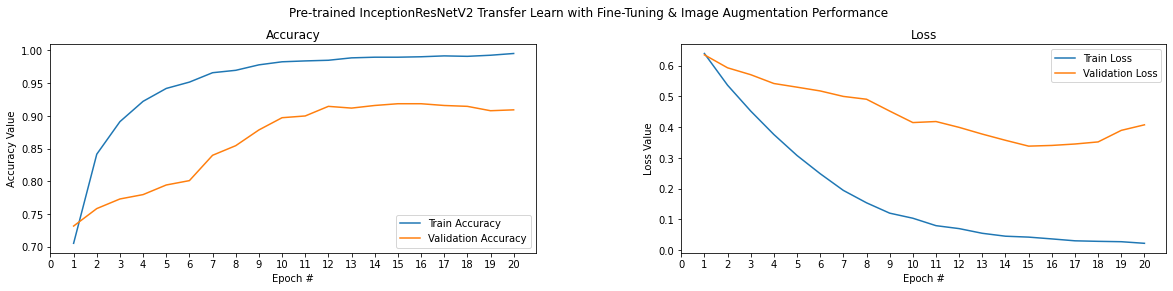

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


True positive =  719
False negative =  40
False positive =  50
True negative =  2936




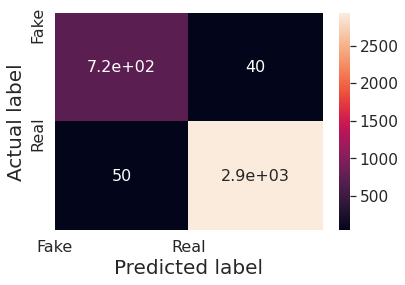

In [ ]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    """
    Plots confusion matrix

    This function gives the rconfusion matrix as output in form of heatmap

    Returns
    -------
    None
    Arguments
    ----------
    y_true: list
    y_pred: list

    """
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False negative = ', cm[0][1])
    print('False positive = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
print_confusion_matrix(Y_val_org, model.predict_classes(X))

# Saving the model

In [ ]:
model.save('/content/gdrive/MyDrive/191010228_191010230_191010239/deepfake-detection-model-inceptionresnetv2.h5')